In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
import collections
from collections import Counter
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from time import time
from keras.layers.merge import add
from keras.layers import Input, Dropout, Dense, LSTM, Embedding

In [ ]:
IMG_PATH = "/gdrive/My Drive/Flicker8k_Dataset/"

In [ ]:
# Function to load captions in memory
def readFile(filename):
    f = open(filename, 'r')
    text = f.read()
    f.close()
    return text

In [ ]:
filename = "/gdrive/My Drive/Flickr8k_text/Flickr8k.token.txt"
doc = readFile(filename)

# Split doc across 'new line' and convert it to list from string.
doc = doc.split('\n')

# Last element in string is empty , so just remove it.
doc = doc[:-1]

In [ ]:
print(len(doc))

40460


In [ ]:
print(type(doc[0]))

<class 'str'>


In [ ]:
first, second = doc[0].split('\t')
print(type(first[1]))
print(type(second))

<class 'str'>
<class 'str'>


In [ ]:
# Map captions to their corresponding image id using Dictionary
descriptions = {}
for i in doc:
    first, second = i.split('\t')
    image_id = first.split('.')[0]

    # If image_id is not present in dictionary, initialize it with empty list
    if descriptions.get(image_id) is None:
        descriptions[image_id] = []
    descriptions[image_id].append(second)

In [ ]:
descriptions['862177617_c2c0581075']

['A girl is wearing a blue wig under a brown hooded jacket .',
 'A man wears an interesting blue wig in public',
 'A person with blue hair , a baseball cap , and a hood on stands outdoors in a crowd .',
 'Man with brown coat and sunglasses wears a blue wig and ball cap .',
 'One person in a crowd of people , wearing a blue wig']

In [ ]:
print(len(descriptions))

8092


#Data Cleaning


In [ ]:
# Remove punctuation marks, number , special characters and word with length 1 to reduce voacb size
def clean_caption(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    sentence = [word for word in sentence if len(word) > 1]
    sentence = ' '.join(sentence)
    return sentence

In [ ]:
# Cleaning all the captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_caption(caption_list[i])

In [ ]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

Writng this to a file "**descriptions**.txt" for future use.

In [ ]:
f = open("/gdrive/My Drive/descriptions.txt", 'w')
f.write(str(descriptions))
f.close()

**Vocabulary**

In [ ]:
def vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [ vocab.update(sentences.split()) for sentences in descriptions[key]]
    return vocab

In [ ]:
vocab = vocabulary(descriptions)
print(len(vocab))

8424


In [ ]:
# Total words across all the sentences
total_words = []

for key in descriptions.keys():
    [ total_words.append(word) for sentences in descriptions[key] for word in sentences.split()]

print("Total Words: ", len(total_words))

Total Words:  373837


In [ ]:
counter = Counter(total_words)
word_freq = dict(counter)

In [ ]:
threshold = 10
total_words = [word for word,freq in word_freq.items() if freq > threshold]

In [ ]:
print(len(total_words))

1845


#Prepare Train/Test Split

In [ ]:
train_file = readFile("/gdrive/My Drive/Flickr8k_text/Flickr_8k.trainImages.txt")
test_file = readFile("/gdrive/My Drive/Flickr8k_text/Flickr_8k.testImages.txt")

In [ ]:
train = [image_id.split(".")[0] for image_id in train_file.split("\n")[:-1]]
test = [image_id.split(".")[0] for image_id in test_file.split("\n")[:-1]]


In [ ]:
test[:5]

['3385593926_d3e9c21170',
 '2677656448_6b7e7702af',
 '311146855_0b65fdb169',
 '1258913059_07c613f7ff',
 '241347760_d44c8d3a01']

In [ ]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [ ]:
# Preparing training description
train_descriptions = {}

for image_id in train:
    train_descriptions[image_id] = []
    for caption in descriptions[image_id]:
        caption_to_append = 'startseq ' + caption + ' endseq'
        train_descriptions[image_id].append(caption_to_append)


In [ ]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

#Transfer Learning

In [ ]:
model = ResNet50(weights="imagenet")
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_18[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
model_new.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_18[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
def preprocess_img(path):
    img = image.load_img(path,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = preprocess_input(img)
    return img

In [ ]:
def encode_image(path):
    img = preprocess_img(path)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector


In [ ]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.04154301, 0.17076042, 0.29278612, ..., 0.05089623, 0.3132239 ,
       0.86007506], dtype=float32)

In [ ]:
# Encode images in trainging set using resnet 
start = time()

encoded_train = {}
for ix,image_id in enumerate(train):
    encoded_train[image_id] = encode_image(IMG_PATH + image_id + ".jpg")
    if ix%500 == 0:
        print("Encoding Continues, Time Step: ", ix)

end = time()
print("Time Elapsed:", end - start)

Encoding Continues, Time Step:  0
Encoding Continues, Time Step:  500
Encoding Continues, Time Step:  1000
Encoding Continues, Time Step:  1500
Encoding Continues, Time Step:  2000
Encoding Continues, Time Step:  2500
Encoding Continues, Time Step:  3000
Encoding Continues, Time Step:  3500
Encoding Continues, Time Step:  4000
Encoding Continues, Time Step:  4500
Encoding Continues, Time Step:  5000
Encoding Continues, Time Step:  5500
Time Elapsed: 131.67715978622437


In [ ]:
with open("/gdrive/My Drive/encoded_train_features.pkl", 'wb') as file:
    pickle.dump(encoded_train,file)

In [ ]:
# Encode images in testing set using resnet 
start = time()

encoded_test = {}
for ix,image_id in enumerate(test):
    encoded_test[image_id] = encode_image(IMG_PATH + image_id + ".jpg")
    if ix%500 == 0:
        print("Encoding Continues, Time Step: ", ix)

end = time()
print("Time Elapsed:", end - start)

Encoding Continues, Time Step:  0
Encoding Continues, Time Step:  500
Time Elapsed: 21.02755308151245


In [ ]:
with open("/gdrive/My Drive/encoded_test_features.pkl", 'wb') as file:
    pickle.dump(encoded_test,file)

#Pre-Processing For Captions

In [ ]:
word_to_idx = {}
idx_to_word = {}
for ix,word in enumerate(total_words):
    word_to_idx[word] = ix+1
    idx_to_word[ix+1] = word

In [ ]:
print(word_to_idx['child'])
print(idx_to_word[1])
print(len(word_to_idx))

1
child
1845


In [ ]:
word_to_idx['startseq']  = 1846
idx_to_word[1846] = 'startseq'
word_to_idx['endseq'] = 1847
idx_to_word[1847] = 'endseq'
vocab_size = len(idx_to_word) + 1

In [ ]:
# Maximum Length of Caption for Padding
max_length = 0

for key in train_descriptions.keys():
    for caption in train_descriptions[key]:
        max_length = max(max_length,len(caption.split()))
print(max_length)
# encoded_train["1000268201_693b08cb0e"]

35


#Data Loader(Generator)

In [ ]:
def data_generator(train_description,encoded_train,max_length,batch_size,word_to_idx):
    X1,X2,Y = list(), list(), list()
    batch_counter = 0
    while True:
        for key,caption_list in train_description.items():

            batch_counter+=1
            features_of_image = encoded_train[key]

            for caption in caption_list:
                seq = [word_to_idx[word] for word in caption.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i] 
                    yi = seq[i]

                    xi = pad_sequences([xi], padding='post',maxlen = max_length)[0]
                    yi = to_categorical([yi], num_classes = vocab_size)[0]

                    X1.append(features_of_image)
                    X2.append(xi)
                    Y.append(yi)

                    if(batch_counter == batch_size):
                        yield [[np.array(X1), np.array(X2)], np.array(Y)]                 
                        X1, X2, Y = [],[],[]
                        batch_counter = 0

Word Embedding

In [ ]:
f = open("/gdrive/My Drive/glove.6B.200d.txt", encoding = 'utf8')

In [ ]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:], dtype = 'float')
    embedding_index[word] = word_embedding

In [ ]:
f.close()
len(embedding_index)

400000

In [ ]:
embedding_index['beach']

array([ 0.0062694,  0.16638  , -0.9911   , -0.87543  , -0.23496  ,
       -0.11415  ,  0.066526 , -0.28033  ,  0.42764  , -0.95074  ,
        0.16984  ,  0.17035  ,  0.55239  ,  0.27563  ,  0.3451   ,
        0.40797  , -0.47017  , -0.21119  , -0.07555  ,  0.44473  ,
       -0.32668  ,  1.5328   ,  0.4799   ,  0.75556  ,  0.6251   ,
        0.11246  , -0.018746 , -0.10466  ,  0.10324  , -0.52646  ,
       -0.084036 ,  0.31446  , -0.37951  , -0.081695 , -0.41864  ,
        0.50637  ,  0.18725  ,  0.54912  ,  0.64609  , -0.1131   ,
        0.049955 ,  0.25383  , -0.10441  ,  0.16225  ,  0.044513 ,
        0.63002  ,  0.66518  ,  0.099118 , -0.062331 ,  1.0103   ,
       -0.33659  , -0.721    , -0.19865  ,  0.34689  ,  0.23475  ,
       -0.35227  , -0.028298 ,  0.23272  , -0.074718 , -0.086888 ,
        0.4342   ,  0.19144  , -0.82861  ,  0.64334  , -0.24199  ,
       -0.25582  , -0.13133  ,  0.16856  ,  0.63814  ,  0.46601  ,
        0.42395  ,  0.0091848, -0.0058569, -0.046291 ,  0.0853

In [ ]:
embedding_dim = 200
def get_embedding_matrix():
    matrix = np.zeros((vocab_size, embedding_dim))
    for word,ix in word_to_idx.items():
        embedding_vector = embedding_index.get(word)

        if embedding_vector is not None:
            matrix[ix] = embedding_vector

    return matrix

In [ ]:
embedding_matrix = get_embedding_matrix()
print(embedding_matrix.shape)

(1848, 200)


# Model Architectur

In [ ]:
# Imput for image featurr vector
input_img_feature = Input(shape = (2048,))
image_layer1 = Dropout(0.4)(input_img_feature)
image_layer2 = Dense(256, activation = 'relu')(image_layer1)

In [ ]:
# Input for caption
input_caption = Input(shape = (max_length,))
caption_layer1 = Embedding(input_dim= vocab_size, output_dim = embedding_dim, mask_zero = True)(input_caption)
caption_layer2 = Dropout(0.4)(caption_layer1)
caption_layer3 = LSTM(256)(caption_layer2)


In [ ]:
# Combining both the model
model_layer1 = add([image_layer2, caption_layer3])
model_layer2 = Dense(256, activation = 'relu')(model_layer1)
output_layer = Dense(vocab_size, activation = 'softmax')(model_layer2)

final_model = Model(inputs = [input_img_feature, input_caption], outputs = output_layer)

In [ ]:
final_model.summary()


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 35)           0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 35, 200)      369600      input_20[0][0]                   
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 2048)         0           input_19[0][0]                   
___________________________________________________________________________________________

In [ ]:
# Use embedding_matrix for word embedding 
final_model.layers[2].set_weights([embedding_matrix])
# Set training to zero
final_model.layers[2].trainable = False

In [ ]:
final_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

#Training 

In [ ]:
epochs = 10
batch_size = 3
steps = len(train_descriptions)//batch_size

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions,encoded_train,max_length,batch_size,word_to_idx)
    final_model.fit_generator(generator, epochs = 1, verbose = 1, steps_per_epoch = steps)


Epoch 1/1
2000/2000 [==============================] - 213s 107ms/step - loss: 3.3992
Epoch 1/1
2000/2000 [==============================] - 209s 104ms/step - loss: 3.1629
Epoch 1/1
2000/2000 [==============================] - 206s 103ms/step - loss: 3.0183
Epoch 1/1
2000/2000 [==============================] - 204s 102ms/step - loss: 2.9117
Epoch 1/1
2000/2000 [==============================] - 207s 104ms/step - loss: 2.8319
Epoch 1/1
2000/2000 [==============================] - 208s 104ms/step - loss: 2.7674
Epoch 1/1
2000/2000 [==============================] - 205s 103ms/step - loss: 2.7125
Epoch 1/1
2000/2000 [==============================] - 203s 102ms/step - loss: 2.6656
Epoch 1/1
2000/2000 [==============================] - 203s 102ms/step - loss: 2.6269
Epoch 1/1
2000/2000 [==============================] - 203s 102ms/step - loss: 2.5938


In [ ]:
train_descriptions['3014169370_fc4059352e']

['startseq man in yellow standing between two waterfalls endseq',
 'startseq man standing between waterfalls endseq',
 'startseq man wearing yellow shirt jumps into lake surrounded by two waterfalls endseq',
 'startseq person wearing yellow shirt just jumped from the top of the waterfall endseq',
 'startseq person wearing yellow shirt stands between two waterfalls endseq']

#Predictions

In [ ]:
def predict_caption(photo):
    text = 'startseq'
    for i in range(max_length):
        sequence = [word_to_idx[word] for word in text.split() if word in word_to_idx]
        sequence = pad_sequences( [sequence], maxlen = max_length, padding = 'post')
        y_hat = final_model.predict([photo, sequence])
        y_hat = y_hat.reshape(-1,)
        y_hat = y_hat.argmax()
        word = idx_to_word[y_hat]
        text += ' ' + word

        if( word == 'endseq'):
            break
    caption = text.split()[1:-1]
    caption = ' '.join(caption)
    return caption

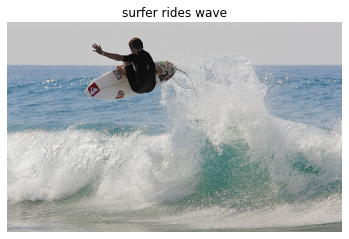

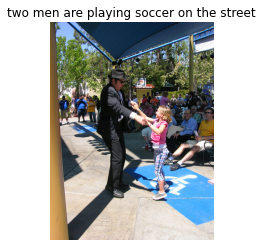

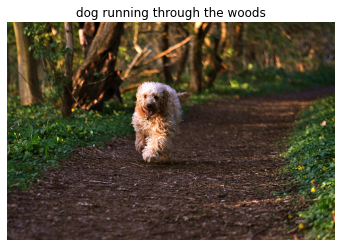

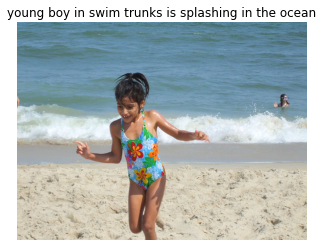

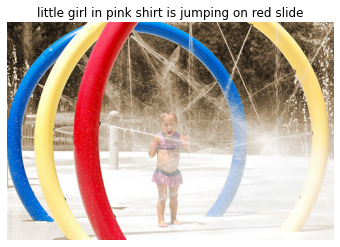

In [ ]:
image_list = list(encoded_test)
for i in range(5):
    photo_id = image_list[np.random.randint(0,1000)]
    photo = plt.imread(IMG_PATH + photo_id + '.jpg')
    photo_features = encoded_test[photo_id]
    photo_features = photo_features.reshape((1,2048))
    caption = predict_caption(photo_features)

    plt.title(caption)
    plt.axis('off')
    plt.imshow(photo)
    plt.show()



